# Explainer notebook

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calplot
import datetime
import folium
from folium.plugins import HeatMapWithTime
import sodapy
from sodapy import Socrata
import pickle
from geopy.distance import distance

Other projects:
- Fire in SF
- Restaurant hygiene/ratings
- NYC car crashes
- complaints 311 call
- traffic

Things to think about:
- normalize to population 

feedback:
- Good questions, answering only some should fine
- correlation with socie-deomographic, poverty


## 1. Motavation

- What is the dataset
- Why this dataset?
- What's the ens goal for user?

## 2. Basic stats

### 2.1 Data loading and cleaning

We'll start by analysing our main dataset, the NYC shooting incidents dataset. (https://data.cityofnewyork.us/Public-Safety/NYPD-Shooting-Incident-Data-Historic-/833y-fsy8)

We will first load the csv file as a pandas dataframe and show the dataframe information. We will also drop the "x_coord_cd" and "y_coord_cd" columns as we don't need both the and the Latitidu/Longitude columns. We will also convert the "OCCUR_DATE" and "OCCUR_TIME" columns to a single "DATETIME" column. We also convert the Latitude and Longitude columns to floats.

In [48]:
# Load data and show info
#df_shooting = pd.read_csv('NYPD_Shooting_Incident_Data__Historic_.csv')

#!pip install sodapy

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

results = client.get_all("833y-fsy8")

# Convert to pandas DataFrame
df_shooting = pd.DataFrame.from_records(results)

# Drop columns
df_shooting = df_shooting.drop(['x_coord_cd', 'y_coord_cd'], axis=1)

# Convert to datetime
df_shooting['datetime']= pd.to_datetime(df_shooting['occur_date'] + ' ' +  df_shooting['occur_time'])
df_shooting = df_shooting.drop(['occur_date', 'occur_time'], axis=1)

# Convert the latitude and longitude values to floats
df_shooting['latitude'] = df_shooting['latitude'].astype(float)
df_shooting['longitude'] = df_shooting['longitude'].astype(float)

# Show info
df_shooting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27312 entries, 0 to 27311
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   incident_key                 27312 non-null  object        
 1   boro                         27312 non-null  object        
 2   precinct                     27312 non-null  object        
 3   jurisdiction_code            27310 non-null  object        
 4   statistical_murder_flag      27312 non-null  bool          
 5   vic_age_group                27312 non-null  object        
 6   vic_sex                      27312 non-null  object        
 7   vic_race                     27312 non-null  object        
 8   latitude                     27302 non-null  float64       
 9   longitude                    27302 non-null  float64       
 10  geocoded_column              27302 non-null  object        
 11  :@computed_region_yeji_bk3q  27302 non-nu

Out dataframe contains 27,312 shooting incidents, which contain information about the date, time and location of the incident, as well as the age, sex and race of both the perpetrator and victim. Furthermore, it also contains a description of the location, and whether ot not the vitim was murdered.

The only columns which contain missing information are 'location_desc', 'perp_age_group', 'perp_sex' and 'perp_race'. The 'location_desc' column contains information about the location of the incident, e.g. whether it's an aprtment building, a public area, etc. So the reason why some data is missing here is because it might not have been reported. The other columns are about the perpetrator. These missing values are likely due to the perpetrator not being found.

We will now look a bit more in depth at some of the columns, to see if we need to perform some more date cleaning.

In [49]:
print(df_shooting['boro'].value_counts(),"\n"*2,
      df_shooting['location_desc'].value_counts().nlargest(10),"\n"*2,
      df_shooting['perp_race'].value_counts(),"\n"*2,
      df_shooting['perp_sex'].value_counts(),"\n"*2,
      df_shooting['perp_age_group'].value_counts())

BROOKLYN         10933
BRONX             7937
QUEENS            4094
MANHATTAN         3572
STATEN ISLAND      776
Name: boro, dtype: int64 

 MULTI DWELL - PUBLIC HOUS    4832
MULTI DWELL - APT BUILD      2835
(null)                        977
PVT HOUSE                     951
GROCERY/BODEGA                694
BAR/NIGHT CLUB                628
COMMERCIAL BLDG               292
RESTAURANT/DINER              204
NONE                          175
BEAUTY/NAIL SALON             112
Name: location_desc, dtype: int64 

 BLACK                             11432
WHITE HISPANIC                     2341
UNKNOWN                            1836
BLACK HISPANIC                     1314
(null)                              640
WHITE                               283
ASIAN / PACIFIC ISLANDER            154
AMERICAN INDIAN/ALASKAN NATIVE        2
Name: perp_race, dtype: int64 

 M         15439
U          1499
(null)      640
F           424
Name: perp_sex, dtype: int64 

 18-24      6222
25-44      5687

We can see that there are some 'NONE' 'U', and 'UNKNOWN' values which we will replace with NaN's, since these are all placeholders for missing/unknown values. Furthermore, the 'perp_age_group' has some values: '1020', '940', '224' which are clearly mistakes, so we will replace these with NaN's as well.

In [50]:
replace_dict = {'NONE': np.nan, 'U': np.nan, '(null)': np.nan, 'UNKNOWN': np.nan, '1020': np.nan, '1022': np.nan, '940': np.nan, '224': np.nan}
df_shooting = df_shooting.replace(replace_dict)
df_shooting.head()

,incident_key,boro,precinct,jurisdiction_code,statistical_murder_flag,vic_age_group,vic_sex,vic_race,latitude,longitude,...,:@computed_region_sbqj_enih,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,perp_age_group,perp_sex,perp_race,location_desc,loc_of_occur_desc,loc_classfctn_desc,datetime
0,228798151,QUEENS,105,0,False,18-24,M,BLACK,40.662965,-73.730839,...,63,24018,63,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-27 21:30:00
1,137471050,BRONX,40,0,False,18-24,M,BLACK,40.810352,-73.924942,...,23,10932,49,NaN,NaN,NaN,NaN,NaN,NaN,2014-06-27 17:40:00
2,147998800,QUEENS,108,0,True,25-44,M,WHITE,40.742607,-73.915492,...,66,14787,53,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-21 03:56:00
3,146837977,BRONX,44,0,False,<18,M,WHITE HISPANIC,40.837782,-73.919457,...,27,10930,50,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-09 18:30:00
4,58921844,BRONX,47,0,True,45-64,M,BLACK,40.886238,-73.852910,...,30,11275,29,25-44,M,BLACK,NaN,NaN,NaN,2009-02-19 22:58:00


### 2.2 Initial data analysis

We will now be perfomrming some initial data analysis on the shooting dataset, in order to get some insights about the dataset and patterns of the shootings in NYC.

#### Time and dates of incidents
We will start by looking at the date and time occurences of the shooting incidents. We will show a bar plot of the number of incidents in each hour of the day, as well as a calendar plot from 2006 to 2021.

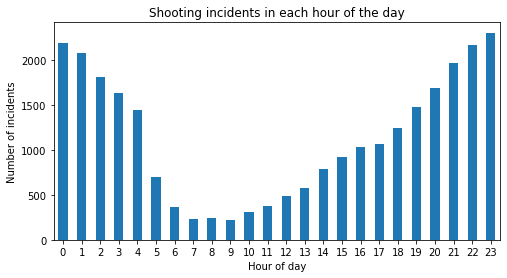

In [5]:
# Get number of incidents in each hour of the day
incidents_hour = df_shooting.datetime.dt.hour.value_counts().reindex(np.arange(24))

# Plot
plt.figure(figsize=(8,4))
incidents_hour.plot.bar(rot=0)
plt.title('Shooting incidents in each hour of the day')
plt.xlabel('Hour of day')
plt.ylabel('Number of incidents')
plt.show()

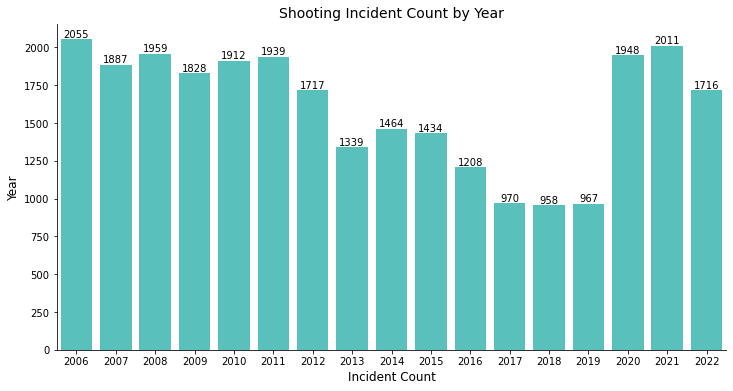

In [6]:
# Get number of incidents in each year
incidents_year = df_shooting.datetime.dt.year.value_counts().sort_index()

# Create horizontal bar plot using Seaborn with the ordered groups
plt.figure(figsize=(12, 6))
sns.barplot(y=incidents_year.values, x=incidents_year.index, color='mediumturquoise')

# Set plot title and axis labels
plt.title('Shooting Incident Count by Year', fontsize=14)
plt.xlabel('Incident Count', fontsize=12)
plt.ylabel('Year', fontsize=12)

# Remove top and right spines
sns.despine()

# Add value labels to bars
for i, v in enumerate(incidents_year.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Show plot
plt.show()

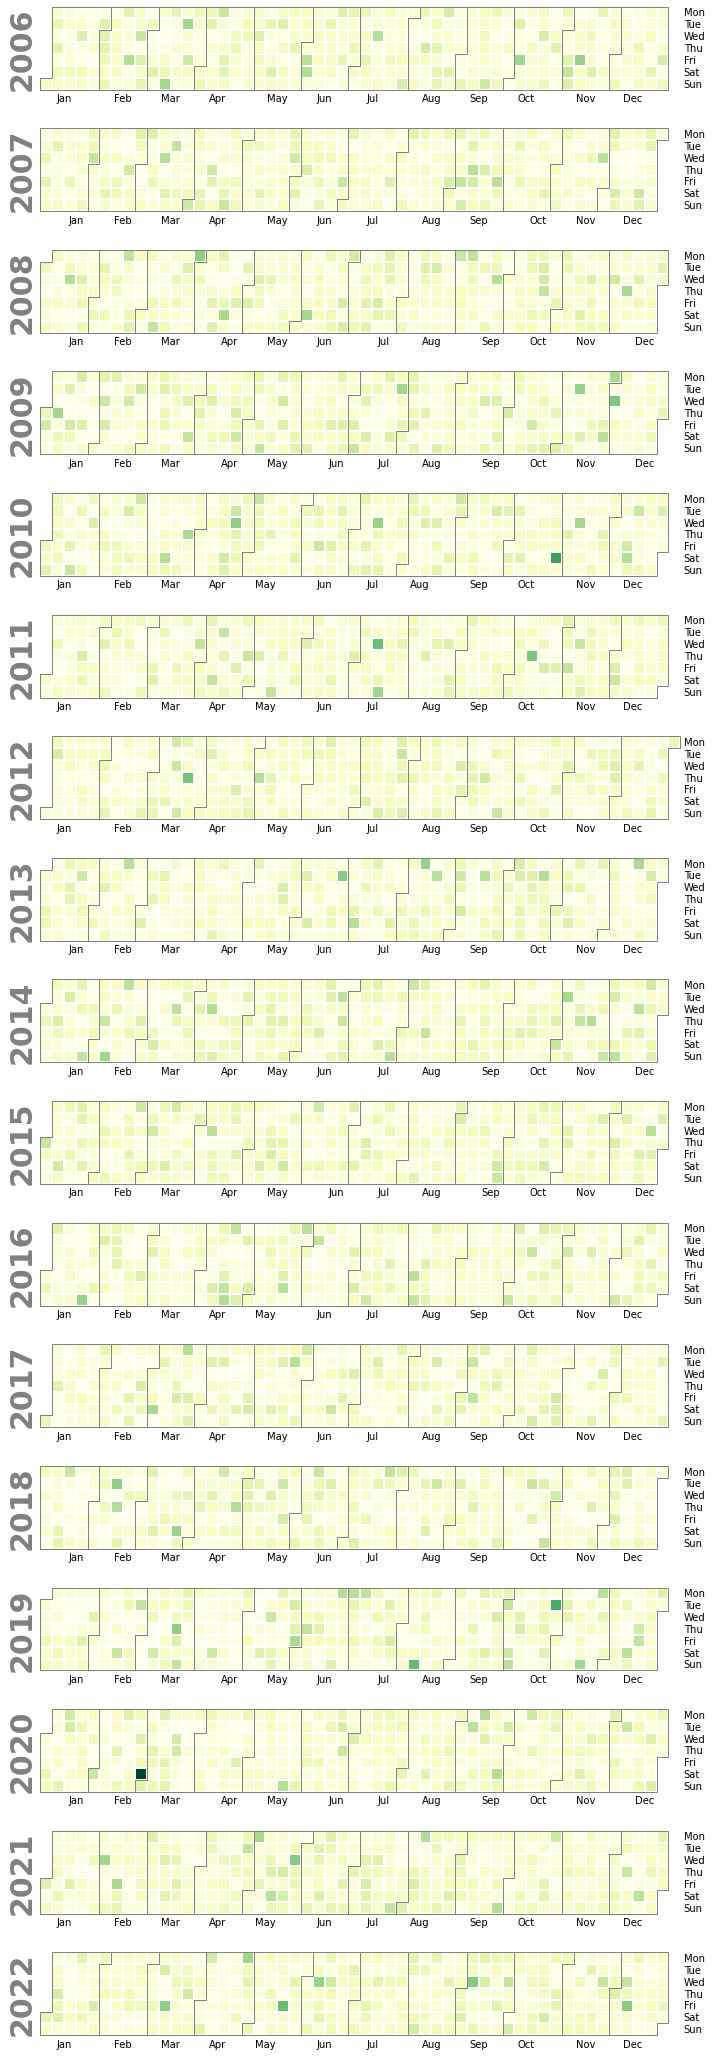

In [7]:
# Calendar plot
all_days = df_shooting.datetime.dt.date.unique().astype('datetime64')
counts = np.array(df_shooting.datetime.dt.date.value_counts().sort_index())
events = pd.Series(counts, index=all_days)
calplot.calplot(events, cmap='YlGn', colorbar=False);

We can see from the bar plot that most shooting incidents occur in the evening or during the night. The calendar plot highlights some dates where a lot of incidents occured, for example in December 2018 there are two consecutive days with a lot of incidents.

#### Location of incidents

We will first look at the location description to see in which kindd of setting shooting incidents are most common.

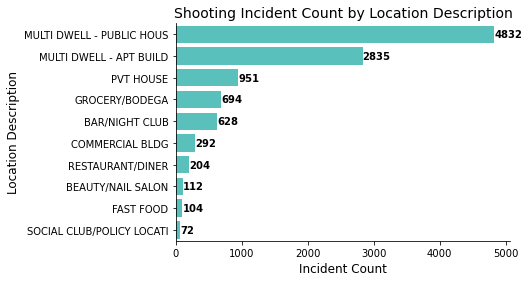

In [8]:
# Define the order of categories based on shooting incident count
incident_count = df_shooting['location_desc'].value_counts().nlargest(10)

# Create horizontal bar plot using Seaborn with the ordered groups
sns.barplot(x=incident_count.values, y=incident_count.index, color='mediumturquoise')

# Set plot title and axis labels
plt.title('Shooting Incident Count by Location Description', fontsize=14)
plt.xlabel('Incident Count', fontsize=12)
plt.ylabel('Location Description', fontsize=12)

# Remove top and right spines
sns.despine()

# Add value labels to bars
for index, value in enumerate(incident_count):
    plt.text(value, index, str(value), ha='left', va='center', fontweight='bold', color='black')

# Show plot
plt.show()

We can see that the majority of shooting incidents in NYC occur in public housing (offered as low-cost housing from the government) and apartments. After that it is areas such as bars, bodegas, and restaurants where most incidents occur.

#### Race, age and gender

We will now look into the distribution of the race, age, and gender of both the perpetrators and the victims. First of all we will investigate whether the age of the victim affects the chance that the shooting incident is a murder.

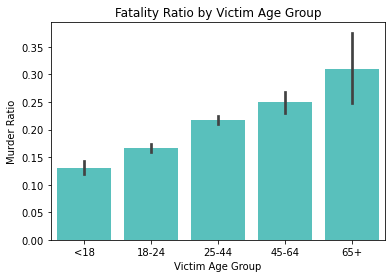

In [9]:
# Calculate murder ratios for each victim age group
murder_ratios = df_shooting.groupby('vic_age_group')['statistical_murder_flag'].mean()

# Sort the murder ratios by ascending order and get the corresponding VIC_AGE_GROUP values
ordered_groups = murder_ratios.sort_values().index.tolist()

# Create bar plot using Seaborn with the ordered groups
sns.barplot(x='vic_age_group', y='statistical_murder_flag', data=df_shooting, order=ordered_groups, color='mediumturquoise')

# Set plot title and axis labels
plt.title('Fatality Ratio by Victim Age Group')
plt.xlabel('Victim Age Group')
plt.ylabel('Murder Ratio')

# Show plot
plt.show()

We can see that there is a clear correlation here. The older the victim is, the higher the chance is that an incident becomes a murder.

We will now investigate the age, race and gender of perpetrators and victims.

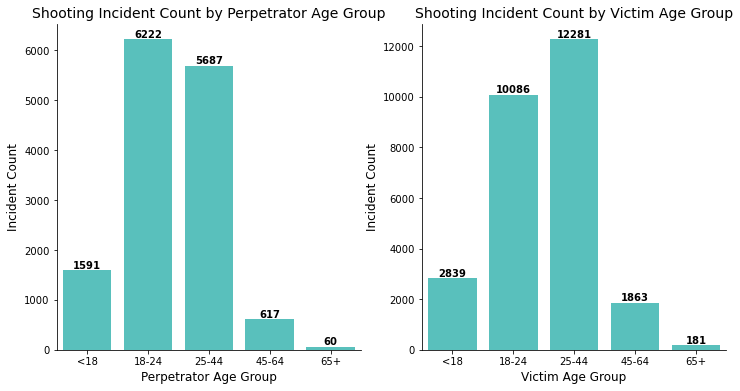

In [10]:
# Define the order of categories based on age group
age_order = ['<18', '18-24', '25-44', '45-64', '65+']

# Calculate shooting incident count for each perpetrator age group
incident_count = df_shooting.groupby('perp_age_group')['incident_key'].count().reindex(age_order)

# Create a grid of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12,6))

# Create the first bar plot in the first subplot
sns.barplot(x=incident_count.index, y=incident_count.values, color='mediumturquoise', ax=axs[0])

# Set plot title and axis labels for the first subplot
axs[0].set_title('Shooting Incident Count by Perpetrator Age Group', fontsize=14)
axs[0].set_xlabel('Perpetrator Age Group', fontsize=12)
axs[0].set_ylabel('Incident Count', fontsize=12)

# Remove top and right spines for the first subplot
sns.despine(ax=axs[0])

# Add value labels to bars in the first subplot
for index, value in enumerate(incident_count):
    axs[0].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')

# Calculate shooting incident count for each victim age group
incident_count_victim = df_shooting.groupby('vic_age_group')['incident_key'].count().reindex(age_order)

# Create the second bar plot in the second subplot
sns.barplot(x=incident_count_victim.index, y=incident_count_victim.values, color='mediumturquoise', ax=axs[1])

# Set plot title and axis labels for the second subplot
axs[1].set_title('Shooting Incident Count by Victim Age Group', fontsize=14)
axs[1].set_xlabel('Victim Age Group', fontsize=12)
axs[1].set_ylabel('Incident Count', fontsize=12)

# Remove top and right spines for the second subplot
sns.despine(ax=axs[1])

# Add value labels to bars in the second subplot
for index, value in enumerate(incident_count_victim):
    axs[1].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')

# Show plot
plt.show()

Here we see that there are actually quite similar distributions of age groups of perpetrators and victims. The vast majority of both perpetrators and victims are in the age groups 18-24 and 25-44. When we look more into the ranges of the groups, we can see that 18-24 only contains 7 years, where as 25-44 and 45-64 both contains 20 years. For the <18 group it is likely that most people in this group are aged close to 17 (at least for the perpetrators, as a 2-year-old is not likely to shoot someone). With these considerations, it seems that young people are generally the ones involved in shooting incidents in NYC.

We will now look into the race of the perpetrators and victims:

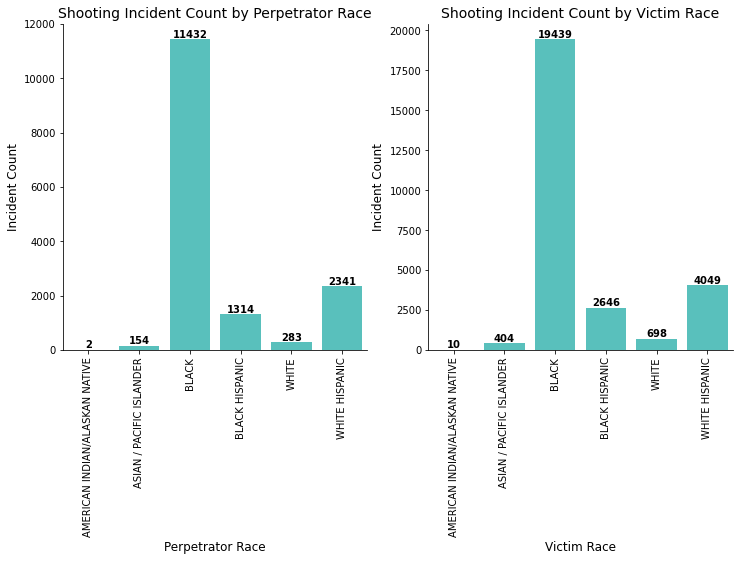

In [11]:
# Calculate shooting incident count for each perpetrator race
incident_count = df_shooting.groupby('perp_race')['incident_key'].count()

# Create a grid of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12,6))

# Create the first bar plot in the first subplot
sns.barplot(x=incident_count.index, y=incident_count.values, color='mediumturquoise', ax=axs[0])

# Set plot title and axis labels for the first subplot
axs[0].set_title('Shooting Incident Count by Perpetrator Race', fontsize=14)
axs[0].set_xlabel('Perpetrator Race', fontsize=12)
axs[0].set_ylabel('Incident Count', fontsize=12)
axs[0].tick_params(axis='x', rotation=90)

# Remove top and right spines for the first subplot
sns.despine(ax=axs[0])

# Add value labels to bars in the first subplot
for index, value in enumerate(incident_count):
    axs[0].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')

# Calculate shooting incident count for each victim race
incident_count_victim = df_shooting.groupby('vic_race')['incident_key'].count()

# Create the second bar plot in the second subplot
sns.barplot(x=incident_count_victim.index, y=incident_count_victim.values, color='mediumturquoise', ax=axs[1])

# Set plot title and axis labels for the second subplot
axs[1].set_title('Shooting Incident Count by Victim Race', fontsize=14)
axs[1].set_xlabel('Victim Race', fontsize=12)
axs[1].set_ylabel('Incident Count', fontsize=12)
axs[1].tick_params(axis='x', rotation=90)

# Remove top and right spines for the second subplot
sns.despine(ax=axs[1])

# Add value labels to bars in the second subplot
for index, value in enumerate(incident_count_victim):
    axs[1].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')


# Show plot
plt.show()

Here we can again see that the distriburion of race is very similar for both the perpetrators and the victims. We are also interested in finding out if most of the incidents involve a perpetrator and victim of the same race, or different race.

The number of incidents where perpetrator and victim have the same race is 10615
The number of incidents where perpetrator and victim have different race is 4869


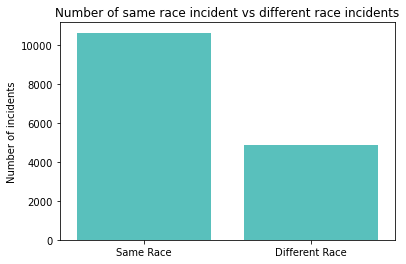

In [12]:
perp_vic_race = np.array(df_shooting[['perp_race','vic_race']].dropna())

same_race = 0
diff_race = 0
for i in perp_vic_race:
    if i[0] == i[1]:
        same_race += 1
    else:
        diff_race += 1
print(f'The number of incidents where perpetrator and victim have the same race is {same_race}')
print(f'The number of incidents where perpetrator and victim have different race is {diff_race}')

plt.figure()
sns.barplot(x=["Same Race", "Different Race"], y=[same_race,diff_race], color='mediumturquoise')
plt.title('Number of same race incident vs different race incidents')
plt.ylabel('Number of incidents')
plt.show()

We will look at the gender of the perpetrators and victims.

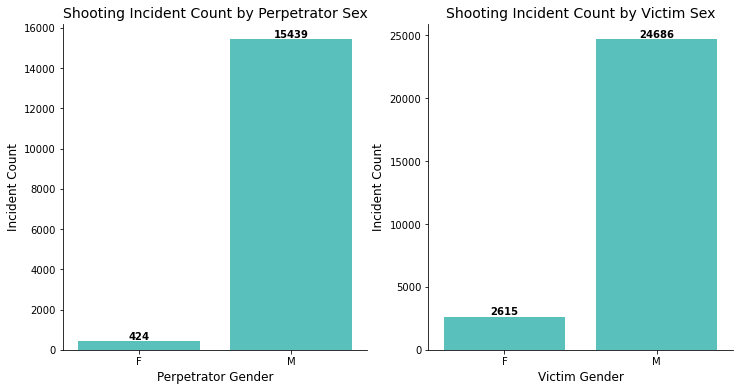

In [13]:
# Calculate shooting incident count for each perpetrator race
incident_count = df_shooting.groupby('perp_sex')['incident_key'].count()

# Create a grid of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12,6))

# Create the first bar plot in the first subplot
sns.barplot(x=incident_count.index, y=incident_count.values, color='mediumturquoise', ax=axs[0])

# Set plot title and axis labels for the first subplot
axs[0].set_title('Shooting Incident Count by Perpetrator Sex', fontsize=14)
axs[0].set_xlabel('Perpetrator Gender', fontsize=12)
axs[0].set_ylabel('Incident Count', fontsize=12)

# Remove top and right spines for the first subplot
sns.despine(ax=axs[0])

# Add value labels to bars in the first subplot
for index, value in enumerate(incident_count):
    axs[0].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')

# Calculate shooting incident count for each victim race
incident_count_victim = df_shooting.groupby('vic_sex')['incident_key'].count()

# Create the second bar plot in the second subplot
sns.barplot(x=incident_count_victim.index, y=incident_count_victim.values, color='mediumturquoise', ax=axs[1])

# Set plot title and axis labels for the second subplot
axs[1].set_title('Shooting Incident Count by Victim Sex', fontsize=14)
axs[1].set_xlabel('Victim Gender', fontsize=12)
axs[1].set_ylabel('Incident Count', fontsize=12)

# Remove top and right spines for the second subplot
sns.despine(ax=axs[1])

# Add value labels to bars in the second subplot
for index, value in enumerate(incident_count_victim):
    axs[1].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')


# Show plot
plt.show()

Almost all the perpetrators are males, and most of the victims are males as well. There is, however, a larger proportion of female vitims than female perpetrators.

#### Shooting incidents by borough

We will now analyse shooting incident in each borough. First by looking at the race distribution of the perpetrators and victims in each borough. We will remove the 'AMERICAN INDIAN/ALASKAN NATIVE' since there are so few occurences of this race.

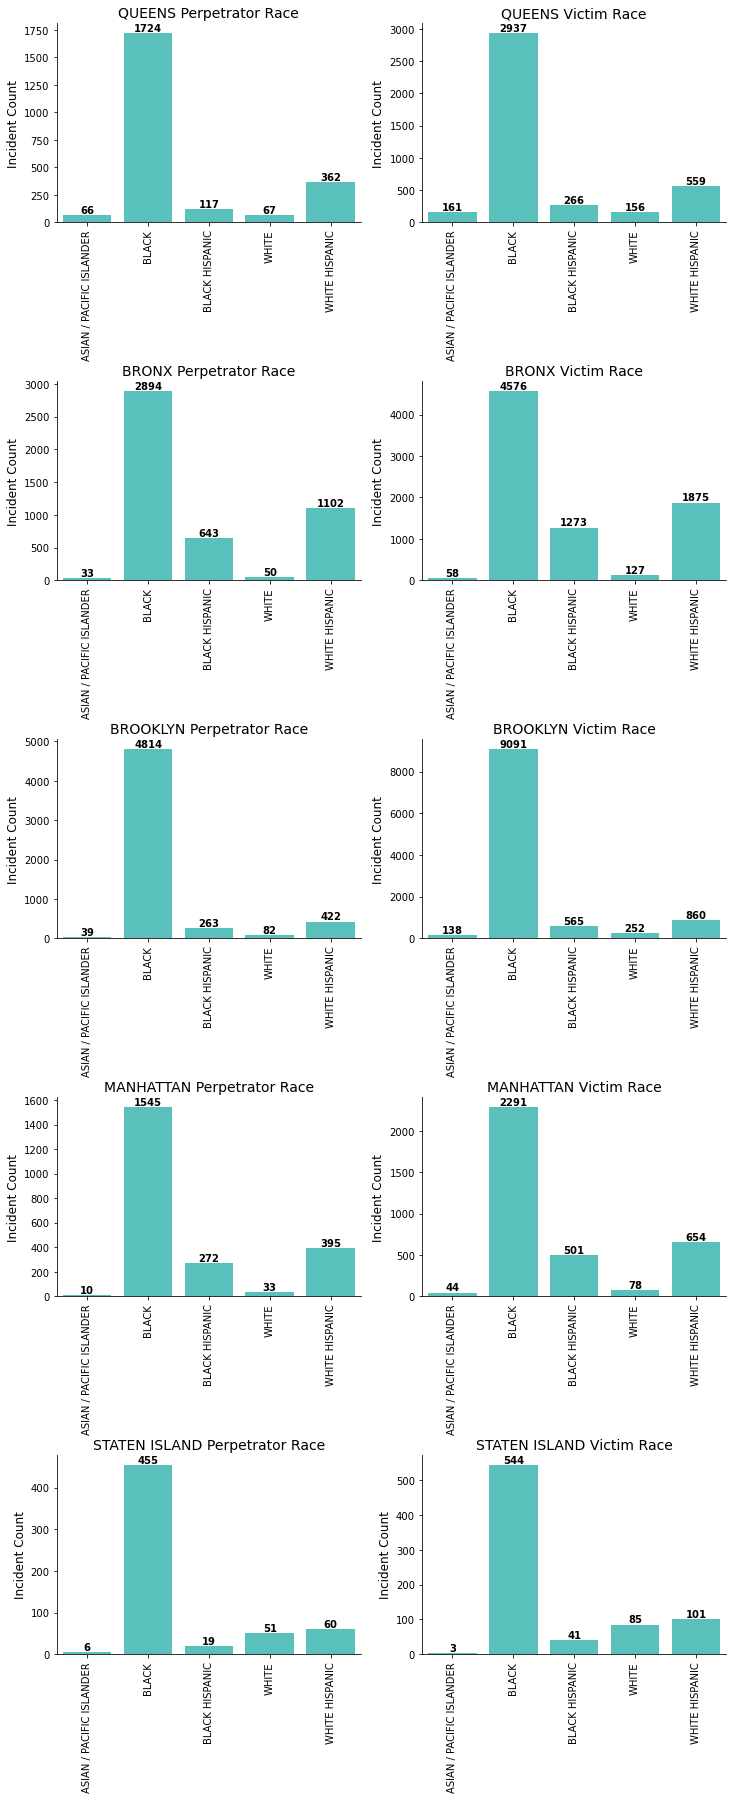

In [14]:
boroughs = df_shooting.boro.unique()
races = sorted(df_shooting.vic_race.dropna().unique())[1:]


# Create a grid of subplots with a row for each borough and 2 columns
fig, axs = plt.subplots(len(boroughs), 2, figsize=(12,30))
plt.subplots_adjust(hspace=0.8)

for i in range(len(boroughs)):
    
    df_temp = df_shooting[df_shooting.boro == boroughs[i]]
    
    # Calculate shooting incident count for each perpetrator race
    incident_count = df_temp.groupby('perp_race')['incident_key'].count().reindex(races)

    # Create the first bar plot in the first subplot
    sns.barplot(x=incident_count.index, y=incident_count.values, color='mediumturquoise', ax=axs[i,0])

    # Set plot title and axis labels for the first subplot
    axs[i,0].set_title(f'{boroughs[i]} Perpetrator Race', fontsize=14)
    axs[i,0].set_xlabel('')
    axs[i,0].set_ylabel('Incident Count', fontsize=12)
    axs[i,0].tick_params(axis='x', rotation=90)

    # Remove top and right spines for the first subplot
    sns.despine(ax=axs[i,0])

    # Add value labels to bars in the first subplot
    for index, value in enumerate(incident_count):
        axs[i,0].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')

    # Calculate shooting incident count for each victim race
    incident_count_victim = df_temp.groupby('vic_race')['incident_key'].count().reindex(races)

    # Create the second bar plot in the second subplot
    sns.barplot(x=incident_count_victim.index, y=incident_count_victim.values, color='mediumturquoise', ax=axs[i,1])

    # Set plot title and axis labels for the second subplot
    axs[i,1].set_title(f'{boroughs[i]} Victim Race', fontsize=14)
    axs[i,1].set_xlabel('')
    axs[i,1].set_ylabel('Incident Count', fontsize=12)
    axs[i,1].tick_params(axis='x', rotation=90)

    # Remove top and right spines for the second subplot
    sns.despine(ax=axs[i,1])

    # Add value labels to bars in the second subplot
    for index, value in enumerate(incident_count_victim):
        axs[i,1].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')

# Show plot
plt.show()

#### Location

Finally, we will do a heatmap over time to show where the shooting incidents occur.

In [15]:
# Get geo locations
geo={"lat": 40.730610 , "lon": -73.935242 }

# Create a list of day-wise data
df_year_list = []

# get a list of all the years
years = sorted(set(df_shooting.datetime.dt.year.unique()))

# Group the data by year and location
for year in years:
    df_year_list.append(df_shooting.loc[df_shooting.datetime.dt.year == year, ['latitude', 'longitude']].groupby(['latitude', 'longitude']).count().reset_index().values.tolist())

# Create a folium map object
map_hooray = folium.Map(location=[geo['lat'], geo['lon']], zoom_start=11, tiles="Stamen Toner")

# Create a list of location data
heat_data = [[row['latitude'], row['longitude']] for index, row in df_shooting.iterrows()]

# Add the heat map with time to the folium map object
HeatMapWithTime(df_year_list, name='test', auto_play=False, max_opacity=1,index=years).add_to(map_hooray)

map_hooray

# Save the map to a file
#map_hooray.save('my_map.html')

## 3. Data Analysis

We will now do some more in-depth analysis of the shooting incidents in NYC. We will look at how it effect various other aspects

### 3.1 Schools

First, we will look at how shooting affects nearby school attendences.

In [45]:
client = Socrata("data.cityofnewyork.us", None)

'''
Takes long time to run
# Define a list of the URLs for the attendance datasets
attendance_urls = [
    "xwxx-rnki",
    "wpqj-3buw",
    "pffu-gbfi",
    "46g3-savk",
    "xc44-2jrh"
]

# Create a list comprehension to read each CSV file into a data frame and store it in a list
dfs = [pd.DataFrame.from_records(client.get_all(url)) for url in attendance_urls]

# Concatenate all the data frames in the dfs list into a single data frame
attendance_df = pd.concat(dfs)

attendance_df.to_csv('Merged_Attendance.csv')
'''

results = client.get_all("qybk-bjjc")

schools_df = pd.DataFrame.from_records(results,columns=['longitude','latitude','dbn'])
schools_df.drop_duplicates(inplace=True)
schools_df['latitude']=schools_df['latitude'].astype(float)
schools_df['longitude']=schools_df['longitude'].astype(float)


attendance_df=pd.read_csv('Merged_Attendance.csv', dtype={'school': str,'date': str},index_col=0)
attendance_df.drop_duplicates(inplace=True)


# drop duplicate rows
attendance_df.drop_duplicates(inplace=True)

num_nan = attendance_df['school'].isnull().sum()
print(f"There are {num_nan} NaN values in column 'school'.")

# drop rows with NaN values in column 'school'
attendance_df.dropna(subset=['school'],inplace=True)


school_df = pd.merge(attendance_df, schools_df, left_on='school', right_on='dbn', how='left')
del school_df['dbn']

# Print the number of rows not found
print(f"{school_df['latitude'].isnull().sum()} rows were not found in the schools dataset.")
school_df.dropna(subset=['latitude'],inplace=True)

school_df['date'] = school_df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d').strftime('%Y-%m-%d'))
school_df['date'] = pd.to_datetime(school_df['date'])
school_df['month'] = (school_df['date'].dt.year-2006)*12+school_df['date'].dt.month
school_df['attendance'] =  (school_df['present']) / school_df['enrolled']

# Prints the first columns and few rows of the dataframe
print(len(school_df))
school_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are 727707 NaN values in column 'school'.
84491 rows were not found in the schools dataset.
2992352


,school,date,schoolyear,enrolled,present,absent,released,longitude,latitude,month,attendance
0,01M015,2006-09-05,20062007,252.0,226.0,26.0,0.0,-73.979022,40.721807,9,0.896825
1,01M015,2006-09-06,20062007,248.0,227.0,21.0,0.0,-73.979022,40.721807,9,0.915323
2,01M015,2006-09-07,20062007,245.0,228.0,17.0,0.0,-73.979022,40.721807,9,0.930612
3,01M015,2006-09-08,20062007,246.0,226.0,20.0,0.0,-73.979022,40.721807,9,0.918699
4,01M015,2006-09-11,20062007,248.0,223.0,25.0,0.0,-73.979022,40.721807,9,0.899194


Number of unique schools: 1676


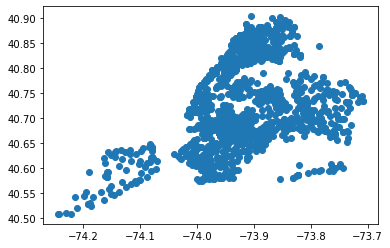

In [214]:
# Make a df of only one of each school
school_list = school_df.copy()
school_list.drop_duplicates(subset=['school'], inplace=True)
print('Number of unique schools:', len(school_list))

# Plot where schools are
long = school_list.longitude.to_numpy()
lat = school_list.latitude.to_numpy()
plt.figure()
plt.scatter(long,lat)
plt.show()

In [219]:
# Get dataframe of average attendance of each school
average_attendance = school_df.groupby(['school','latitude','longitude'])['attendance'].mean()
average_attendance = average_attendance.reset_index()

# Define a color scale based on attendance percentage
color_scale = folium.LinearColormap(
    ['red', 'yellow', 'green'],
    vmin = 0.82,
    vmax = 1
)

# Create a folium map centered on the United States
map = folium.Map(location=[40.7202, -73.9129], zoom_start=10, tiles="Stamen Toner")

# Add a marker for each school with a color based on attendance percentage
for i, row in average_attendance.iterrows():
    color = color_scale(row['attendance']) # get color based on attendance percentage
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=8, # adjust size of circle marker as needed
                        color=color,
                        fill=True,
                        fill_color=color,
                        opacity=0,
                        fill_opacity=0.4).add_to(map)

# Add a color scale legend to the map
color_scale.add_to(map)

# Display the map
map

We now want to check how a shooting incident effects the school attendence on the day of the incident as well as the day after. We do so by taking the average attendace when there was a shooting incident within 1km og the school on the day or the day before, as well as the average attendance when there wasn't a shooting incident nearby.

In [130]:
# df_shooting['date'] = pd.to_datetime(df_shooting['datetime'], format='%Y-%m-%d').dt.date
# df_shooting['date'] = pd.to_datetime(df_shooting['date'])

# # define start and end dates
# start_date = pd.to_datetime('2006-09-05')
# end_date = pd.to_datetime('2017-06-28')
# df_shooting = df_shooting.loc[(df_shooting['datetime'] >= start_date) & (df_shooting['datetime'] <= end_date)]

# # Make a dictionary to get all dates where a shooting occurred within 1 km for each school
# # Takes a long time to run - have saved result in a pickle
# shootings = {}

# # define a function to calculate distance between two points
# def get_distance(lat1, lon1, lat2, lon2):
#     return distance((lat1, lon1), (lat2, lon2)).km

# # loop over each row of the attendance dataframe and get list of dates with shootings within 1km
# i = 0
# for idx, row in school_list.iterrows():
#     i += 1
#     school_lat = row['latitude']
#     school_lon = row['longitude']
#     dates_with_shootings = []
#     for idx2, row2 in df_shooting.iterrows():
#         shooting_lat = row2['latitude']
#         shooting_lon = row2['longitude']
#         shooting_date = row2['date']
#         dist = get_distance(school_lat, school_lon, shooting_lat, shooting_lon)
#         # if dist <= 1 and shooting_date not in dates_with_shootings:
#         if dist <= 1:
#             dates_with_shootings.append(shooting_date)
#     shootings[row['school']] = dates_with_shootings
#     if i%10 == 0:
#         print(i)

# Load
with open('shooting_school.pickle', 'rb') as handle:
    shootings = pickle.load(handle)

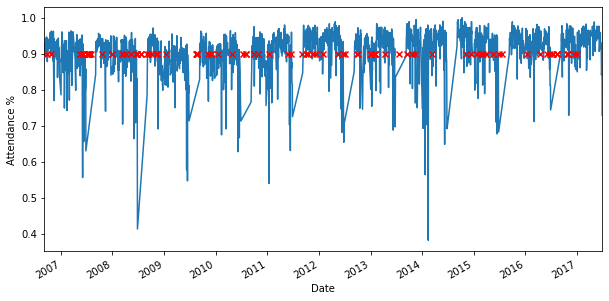

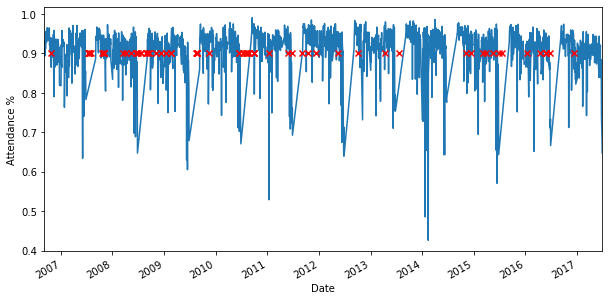

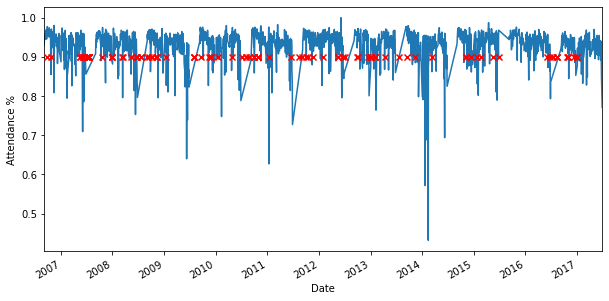

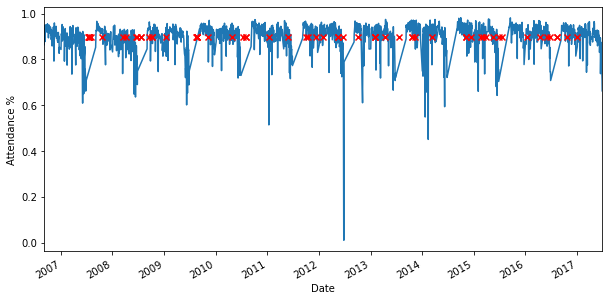

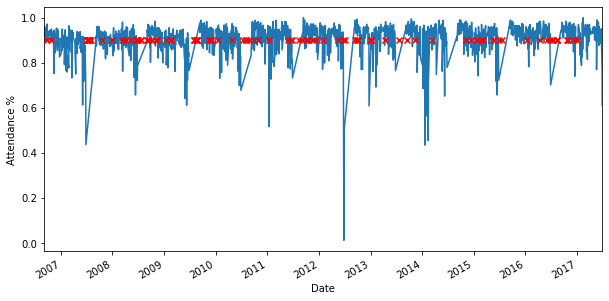

In [213]:
# Plot 
individual_schools = school_df.groupby('school')
for i in range(5):
    fig, ax = plt.subplots(figsize=(10, 5))
    temp = individual_schools.get_group(schools[i])
    temp.plot(x='date', y='attendance', legend=False, ax=ax)
    ax.set_xlabel("Date")
    ax.set_ylabel("Attendance %")
    ax.scatter(shootings[schools[i]], 0.9*np.ones(len(shootings[schools[i]])), marker='x', color='red', zorder=10)
    ax.set_xlim(temp.date.min(), temp.date.max())
    plt.show()

In [173]:
# Add boolean column for shooting incident on same day and day before
school_df['shooting_same_day'] = school_df.apply(lambda row: row['date'] in shootings[row['school']], axis=1)
school_df['shooting_prev_day']=school_df.apply(lambda row: row['date']-pd.Timedelta(days=1) in shootings[row['school']], axis=1)
school_df.head()

,school,date,schoolyear,enrolled,present,absent,released,longitude,latitude,month,attendance,shooting_same_day,shooting_prev_day
0,01M015,2006-09-05,20062007,252.0,226.0,26.0,0.0,-73.979022,40.721807,9,0.896825,False,False
1,01M015,2006-09-06,20062007,248.0,227.0,21.0,0.0,-73.979022,40.721807,9,0.915323,False,False
2,01M015,2006-09-07,20062007,245.0,228.0,17.0,0.0,-73.979022,40.721807,9,0.930612,False,False
3,01M015,2006-09-08,20062007,246.0,226.0,20.0,0.0,-73.979022,40.721807,9,0.918699,False,False
4,01M015,2006-09-11,20062007,248.0,223.0,25.0,0.0,-73.979022,40.721807,9,0.899194,False,False


In [203]:
school_with_shooting = school_df[(school_df['shooting_same_day']) | (school_df['shooting_prev_day'])]
school_without_shooting = school_df[~(school_df['shooting_same_day'] | school_df['shooting_prev_day'])]

In [212]:
print('Average attendance based on all attendances')
with_shooting_mean = school_with_shooting.present.sum()/school_with_shooting.enrolled.sum()
without_shooting_mean = school_without_shooting.present.sum()/school_without_shooting.enrolled.sum()
print(f'When there was a shooting incident within 1km same day or day before: {with_shooting_mean}')
print(f'When there was no shooting incident within 1km same day or day before: {without_shooting_mean}')

print('\nAverage attendance based on school')
with_shooting_mean = school_with_shooting.attendance.mean()
without_shooting_mean = school_without_shooting.attendance.mean()
print(f'When there was a shooting incident within 1km same day or day before: {with_shooting_mean}')
print(f'When there was no shooting incident within 1km same day or day before: {without_shooting_mean}')

Average attendance based on all attendances
When there was a shooting incident within 1km same day or day before: 0.8876784809034535
When there was no shooting incident within 1km same day or day before: 0.9067410160605628

Average attendance based on school
When there was a shooting incident within 1km same day or day before: 0.8795778639369731
When there was no shooting incident within 1km same day or day before: 0.8969941856264902


## 4. Genre

## 5. Visualizations

## 6. Discussion

## 7. Contributions